## <center>inspired by this tweet https://twitter.com/MEKhoko/status/981868845794283520</center>

<img src="fundstrat.jpg">

In [93]:
# Imports
%matplotlib inline
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
# Get price data from Quandl
data = quandl.get("BCHAIN/MKPRU")
data = data.shift(-1) # data set has daily open, we want daily close

In [95]:
# Take a look
data.head()

,Value
Date,
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0
2009-01-06,0.0
2009-01-07,0.0


In [96]:
# See where the 0's end
data.loc[data['Value'] > 0].head()

,Value
Date,
2010-08-16,0.076900
2010-08-17,0.074000
2010-08-18,0.068800
2010-08-19,0.066700
2010-08-20,0.066899


In [97]:
# Remove the 0's
data = data.loc['2010-08-17':]

In [98]:
# Look again
data.head()

,Value
Date,
2010-08-17,0.074000
2010-08-18,0.068800
2010-08-19,0.066700
2010-08-20,0.066899
2010-08-21,0.066400


In [99]:
# Summary, no. of rows looks correct
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2801 entries, 2010-08-17 to 2018-04-17
Data columns (total 1 columns):
Value    2800 non-null float64
dtypes: float64(1)
memory usage: 43.8 KB


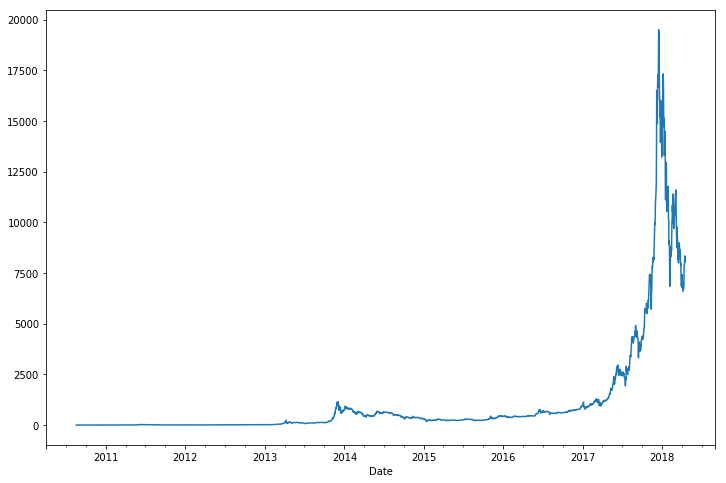

In [100]:
# Visual check of price data
data['Value'].plot(figsize=(12,8))

/Users/danielcimring/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


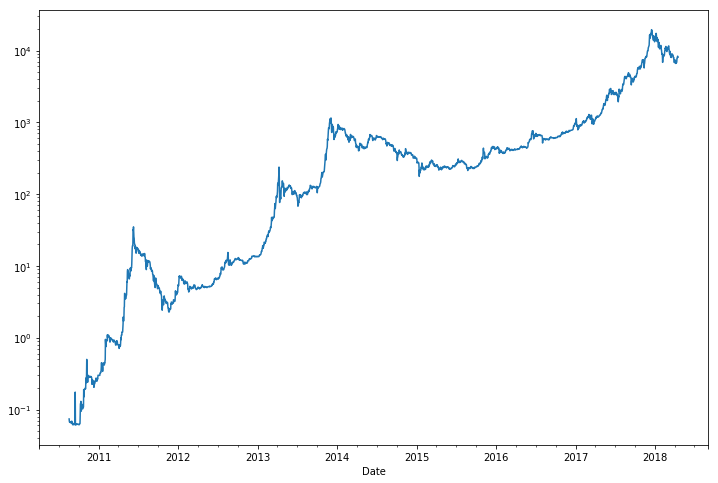

In [101]:
# Using a log scale
data['Value'].plot(figsize=(12,8), logy=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11be32710>,
      dtype=object)

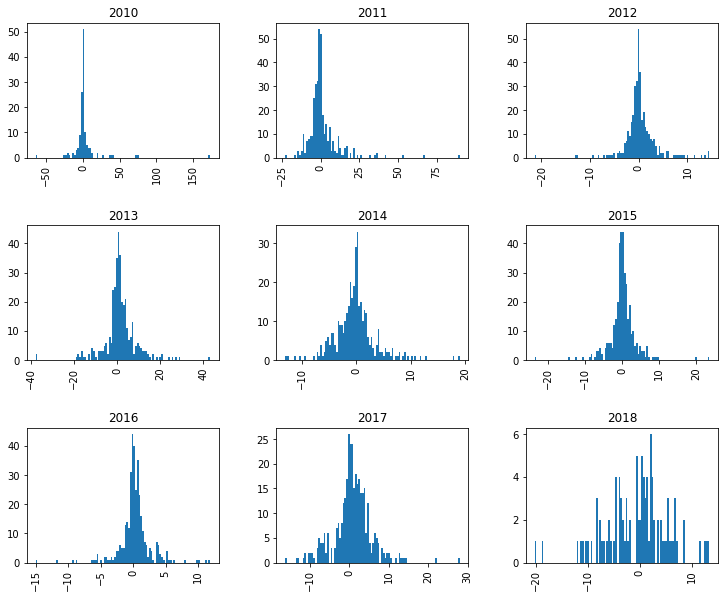

In [58]:
# Freq plot by year showing distribution of returns
(data.pct_change() * 100).hist(bins=100, figsize = (12,10), by = lambda x: x.year)

In [59]:
# Best and worst days from entire data set
print "Worst" + "-" * 20
print((data['Value'].pct_change() * 100).dropna().sort_values().head(10).sort_values())
print "Best" + "-" * 20
print((data['Value'].pct_change() * 100).dropna().sort_values().tail(10).sort_values(ascending = False))

Worst--------------------
Date
2010-09-15   -64.628571
2013-04-11   -38.016700
2013-04-10   -37.676273
2010-11-07   -25.999852
2010-10-11   -23.904689
2015-01-13   -23.556672
2011-10-17   -22.871520
2012-08-18   -21.363762
2010-10-24   -21.052632
2010-11-09   -20.813539
Name: Value, dtype: float64
Best--------------------
Date
2010-09-14    173.010920
2011-01-31     90.000000
2010-10-23     74.295936
2010-11-06     72.413448
2011-06-07     67.418153
2011-04-29     53.702222
2013-04-12     43.159698
2011-05-12     42.017284
2010-11-02     40.664962
2010-10-07     37.931034
Name: Value, dtype: float64


In [60]:
# Group by year, calculate yearly returns, drop years without full year of data
data_annual = data.asfreq("Y")
data_annual['Returns'] = data_annual['Value'].pct_change() * 100
data_annual.index = data_annual.index.year
data_annual.dropna(inplace=True)

In [61]:
# Take a look at results
data_annual['Returns'].head(10)

Date
2011    1633.344889
2012     160.788462
2013    5407.705921
2014     -57.731959
2015      35.996199
2016     123.568733
2017    1375.780574
Name: Returns, dtype: float64

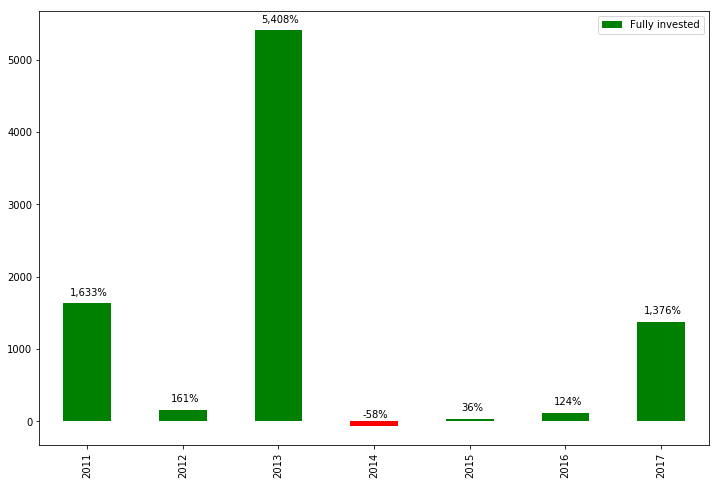

In [62]:
# Chart the results
colors = np.sign(data_annual['Returns']).map({1 : 'g', -1 : 'r'}).values
data_annual.index.name = '' # Don't want to show 'Date' as a label on chart
ax = data_annual['Returns'].plot(kind='bar', figsize=(12,8),color = colors)
ax.legend(["Fully invested"]);
for p in ax.patches:
    b = p.get_bbox()
    val = "{:,.0f}%".format(b.y1 + b.y0)        
    ax.annotate(val,((b.x0 + b.x1) / 2 + len(val) * -0.03, b.y1 + 110))

In [63]:
# Back to daily data, calculate returns from prices and then group by year
data['Returns'] = data['Value'].pct_change()
data.dropna(inplace = True)
returns_by_year = data.groupby(lambda x: x.year)

In [92]:
# Go through each year, find the top 10 days, then calculate returns with and without

dates = []

data_annual['MissTop10'] = 0.0
data_annual['MissTop5'] = 0.0

for year, frame in returns_by_year:
    
    full_return = (frame['Returns'] + 1).cumprod()[-1] - 1
    top10 = frame['Returns'].sort_values()[-10:]
    top5 = top10[-5:]
    top10_return = (top10 + 1).cumprod()[-1] - 1
    top5_return = (top5 + 1).cumprod()[-1] - 1
    full_less_top10_return = ((1 + full_return) / (1 + top10_return)) - 1
    full_less_top5_return = ((1 + full_return) / (1 + top5_return)) - 1
    
    data_annual.loc[year, 'MissTop10'] = full_less_top10_return * 100
    data_annual.loc[year, 'MissTop5'] = full_less_top5_return * 100
    
    print year, '-' * 30 
    # print top10.index
    if year >= 2012:
        dates += list(top10.index.astype(str))
    print "Full year return {:,.0f}%".format(full_return * 100 )
    print "top 10 days return {:,.0f}%".format(top10_return * 100)
    print "Return if miss 10 top days {:,.0f}%".format(full_less_top10_return * 100)
    #if year in [2017]:
    print "10 best days"
    print top10[::-1] * 100

print(dates)

2010 ------------------------------
Full year return 305%
top 10 days return 4,403%
Return if miss 10 top days -91%
10 best days
Date
2010-09-14    173.010920
2010-10-23     74.295936
2010-11-06     72.413448
2010-11-02     40.664962
2010-10-07     37.931034
2010-10-08     36.375000
2010-10-25     26.666667
2010-11-05     20.883702
2010-11-12     19.521912
2010-10-14     13.333333
Name: Returns, dtype: float64
2011 ------------------------------
Full year return 1,633%
top 10 days return 3,489%
Return if miss 10 top days -52%
10 best days
Date
2011-01-31    90.000000
2011-06-07    67.418153
2011-04-29    53.702222
2011-05-12    42.017284
2011-08-08    36.107987
2011-04-27    35.897436
2011-06-02    35.288553
2011-05-09    32.080264
2011-04-23    25.887669
2011-05-25    24.234354
Name: Returns, dtype: float64
2012 ------------------------------
Full year return 161%
top 10 days return 203%
Return if miss 10 top days -14%
10 best days
Date
2012-07-16    14.476652
2012-08-26    14.416059


In [65]:
# View the results
data_annual.dropna(inplace = True)
data_annual.head(10)

,Value,Returns,MissTop10,MissTop5
,,,,
2011,5.200,1633.344889,-51.706494,83.410366
2012,13.561,160.788462,-13.849582,36.267335
2013,746.900,5407.705921,513.529183,1392.509398
2014,315.700,-57.731959,-86.135490,-78.457498
2015,429.340,35.996199,-50.563494,-29.804194
2016,959.870,123.568733,4.918951,38.110350
2017,14165.575,1375.780574,257.705112,537.173617


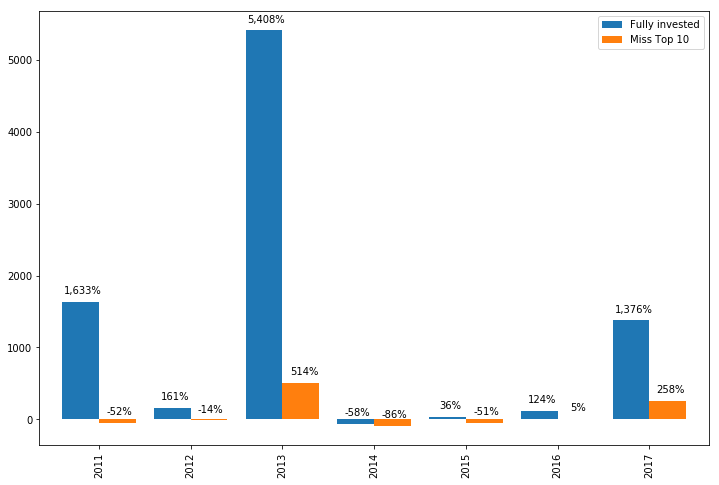

In [66]:
# Chart the results
ax = data_annual[['Returns','MissTop10']].plot(kind='bar', figsize=(12,8), width = 0.8)
ax.legend(["Fully invested", "Miss Top 10"]);
for p in ax.patches:
    b = p.get_bbox()
    val = "{:,.0f}%".format(b.y1 + b.y0)        
    ax.annotate(val,((b.x0 + b.x1) / 2 + len(val) * -0.03, b.y1 + 110))


In [79]:
# Calculate total returns for period and compound annual returns
print "Total returns"
print "-" * 25
print "Fully invested since start 2011 {:,.0f}%".format((((data_annual['Returns'] / 100 + 1).cumprod().iloc[-1])- 1) * 100)
print "Missed top 10 each year {:,.0f}%".format((((data_annual['MissTop10'] / 100 + 1).cumprod().iloc[-1]) - 1) * 100)
print "Missed top 5 each year {:,.0f}%".format((((data_annual['MissTop5'] / 100 + 1).cumprod().iloc[-1])- 1) * 100)
print
print "Compound annual returns"
print "-" * 25
print "Fully invested since start 2011 {:,.1f}%".format((((data_annual['Returns'] / 100 + 1).cumprod().iloc[-1]) ** (1.0/len(data_annual)) - 1) * 100)
print "Missed top 10 each year {:,.1f}%".format((((data_annual['MissTop10'] / 100 + 1).cumprod().iloc[-1]) ** (1.0/len(data_annual)) - 1) * 100)
print "Missed top 5 each year {:,.1f}%".format((((data_annual['MissTop5'] / 100 + 1).cumprod().iloc[-1]) ** (1.0/len(data_annual)) - 1) * 100)

Total returns
-------------------------
Fully invested since start 2011 4,721,790%
Missed top 10 each year -34%
Missed top 5 each year 4,864%

Compound annual returns
-------------------------
Fully invested since start 2011 365.3%
Missed top 10 each year -5.8%
Missed top 5 each year 74.7%


In [70]:
# sanity check on 2013 returns
start, end = data.loc['2012-12-31','Value'], data.loc['2013-12-31','Value']
print start, end
print (end / start - 1) * 100
print ((data.loc['2013-1-1':'2013-12-31','Returns'] + 1).cumprod()[-1] - 1) * 100

# check prices a few days before and after
print data.loc['2012-12-25':'2013-01-5','Value']
print data.loc['2013-12-25':'2014-01-5','Value']

# sanity check on total returns
start, end = data.loc['2010-12-31','Value'], data.loc['2017-12-31','Value']
print start, end
print (end / start - 1) * 100
print ((data.loc['2011-1-1':'2017-12-31','Returns'] + 1).cumprod()[-1] - 1) * 100

13.561 746.9
5407.7059213922275
5407.705921392224
Date
2012-12-25    13.39890
2012-12-26    13.47000
2012-12-27    13.64990
2012-12-28    13.67000
2012-12-29    13.56998
2012-12-30    13.59000
2012-12-31    13.56100
2013-01-01    13.40000
2013-01-02    13.46400
2013-01-03    13.48986
2013-01-04    13.54800
2013-01-05    13.52999
Name: Value, dtype: float64
Date
2013-12-25    734.42
2013-12-26    715.51
2013-12-27    701.61
2013-12-28    714.79
2013-12-29    739.10
2013-12-30    731.00
2013-12-31    746.90
2014-01-01    758.01
2014-01-02    806.21
2014-01-03    822.38
2014-01-04    896.00
2014-01-05    934.21
Name: Value, dtype: float64
0.299998 14165.575
4721789.812598752
4721789.81259875


In [71]:
stats = returns_by_year.describe().drop(columns=['Value'], axis = 1)

In [72]:
stats.columns = [u'count', u'mean', u'std', u'min', u'25%', u'50%', u'75%', u'max']

In [73]:
stats['skew'] = 3 * (stats['mean'] - stats['50%']) / stats['std'] # Pearson Median Skewness
stats

,count,mean,std,min,25%,50%,75%,max,skew
2010,136.0,0.024930,0.201400,-0.646286,-0.016380,0.000000,0.019319,1.730109,0.371343
2011,365.0,0.012189,0.102492,-0.228715,-0.031291,-0.007201,0.027983,0.900000,0.567564
2012,366.0,0.003167,0.033017,-0.213638,-0.009172,0.000000,0.012097,0.144767,0.287733
2013,365.0,0.013870,0.074678,-0.380167,-0.011880,0.009049,0.038661,0.431597,0.193670
2014,365.0,-0.001677,0.037173,-0.130463,-0.019533,-0.001610,0.013322,0.190434,-0.005387
2015,365.0,0.001485,0.035803,-0.235567,-0.009617,0.001043,0.013704,0.235751,0.037055
2016,366.0,0.002513,0.024943,-0.150515,-0.004369,0.001934,0.009971,0.118442,0.069694
2017,365.0,0.008573,0.048811,-0.161979,-0.010423,0.008752,0.032550,0.279686,-0.011018
2018,101.0,-0.005212,0.060226,-0.202052,-0.039201,0.003159,0.025344,0.133803,-0.416999


In [74]:
# skew by year (3rd standardised moment)
[(year, frame['Returns'].skew()) for year, frame in returns_by_year]

[(2010, 5.004115483320167),
 (2011, 3.5927591004080996),
 (2012, 0.10892790283057956),
 (2013, -0.013816177281385686),
 (2014, 0.8033188638876836),
 (2015, 0.13548413153021976),
 (2016, -0.3676355846793451),
 (2017, 0.4004076979139101),
 (2018, -0.41592180494151687)]

In [77]:
data.loc['2017-12-06':].head(10)

,Value,Returns
Date,,
2017-12-06,13540.980000,0.139963
2017-12-07,16501.971667,0.218669
2017-12-08,16007.436667,-0.029968
2017-12-09,15142.834152,-0.054013
2017-12-10,14869.805000,-0.018030
2017-12-11,16762.116667,0.127259
2017-12-12,17276.393333,0.030681
2017-12-13,16808.366667,-0.027091
2017-12-14,16678.892000,-0.007703
